This notebook contains benchmarks to determine the rules about which method should be chosen for a given case of distance evaluation. This compares the function capped distance function for three different data structures i.e. brute force method (``bruteforce``), cell-list data structure(``nsgrid``), and KDtree structure(``pkdtree``). The original distance evaluation functions reside in ``lib`` module of MDAnalysis where ``capped function`` is a wrapper around these methods. While the original functions are faster, the wrapper evaluates the pairs and distances, which are desired for most of the applications. 

Tiem for distance evaluations primarily depends on the size of data set, and desired cutoff radius. Furthermore, for MD simulations, periodic boundary conditions also add to the parameter space of distance evaluations. 

In these Benchmarks, we will first understand how the timings vary with change in the size of data followed by variation of cutoff distance for couple of different sizes to understand the variation. This will be followed by a similar study with No Periodic boundary condition

In [3]:
import MDAnalysis as mda
from MDAnalysis.lib.distances import capped_distance, self_capped_distance
import numpy as np

In [4]:
%matplotlib inline

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
#Helper function for generating the coordinates
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

Lets begin with single queries, primarily with a cutoff radius of 4 units

In [5]:
Npoints = np.logspace(2, 5, num=10, dtype=np.int)
max_dist = 4.0
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)

In [6]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(box, N)
    
    res = %timeit -q -o capped_distance(points[0], points, max_dist, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o capped_distance(points[0], points, max_dist, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o capped_distance(points[0], points, max_dist, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['N'].append(N)

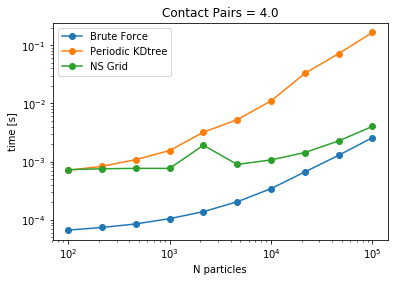

In [8]:
fig, axes = plt.subplots()

axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['N'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

As anticipated, for single queries, brute force is the best till a certain size where the cost of constructing a data structure is less than checking all the points. Also, KDTree construction costs are higher than Celllists

Lets try to extend the size of query keeping the data size fixed. This will give a better idea on search time for single query other than the overhead cost of data structure construction. As a test case,  particle set of `100000 atoms` is chosen here.

In [17]:
Npoints = 100000
max_dist = 4.0
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
nquery = np.logspace(1, 5, num=10, dtype=np.int)

In [ ]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

points = get_coords(box, Npoints)
for n in tqdm_notebook(np.unique(nquery)):
    
    
    res = %timeit -q -o capped_distance(points[:n], points, max_dist, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o capped_distance(points[:n], points, max_dist, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o capped_distance(points[:n], points, max_dist, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['N'].append(n)

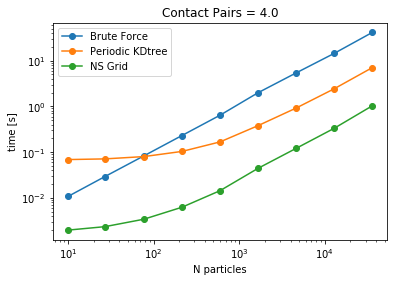

In [20]:
fig, axes = plt.subplots()

axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['N'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

This shows that cell-list is almost always better for searching pairs between two different sets of particles.

But the above statement is true for a cutoff distance of 4 units. Lets check if the relationship holds true for all other cutoff radius. Here again, we begin with single queries

In [12]:
cutoff = np.linspace(1, 15, num=15, dtype=np.float)
Npoints = 100000
box = np.array([100, 100, 100, 90, 90, 90], dtype=np.float32)
points = get_coords(box,Npoints)
query = points[0]

In [13]:
result = defaultdict(list)

points = get_coords(box, Npoints)
for cut in tqdm_notebook(np.unique(cutoff)):
    
    res = %timeit -q -o capped_distance(query, points, cut, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o capped_distance(query, points, cut, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o capped_distance(query, points, cut, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['cut'].append(cut)

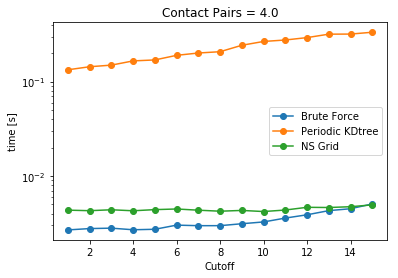

In [14]:
fig, axes = plt.subplots()

axes.plot(result['cut'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['cut'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['cut'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='Cutoff', ylabel='time [s]',  yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

As expected, the trend is similar to the single query search done previously, however, at larger cutoff distances, cell-list becomes advantageous over brute force method. This should be reflected in multiple queries as well

In [15]:
# Increased number of queries

In [19]:
Npoints = 100000
cutoff = np.linspace(1, 15, num=15, dtype=np.float)
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
nquery = np.logspace(2, 4, num=3, dtype=np.int)

In [22]:
from collections import defaultdict

result = defaultdict(list)

points = get_coords(box, Npoints)
for n in tqdm_notebook(np.unique(nquery)):
    for cut in tqdm_notebook(np.unique(cutoff)):
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='bruteforce')
        result['bf'+'.'+str(n)].append(res.average)
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='pkdtree')
        result['pkdtree'+'.'+str(n)].append(res.average)
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='nsgrid')
        result['nsgrid'+'.'+str(n)].append(res.average)
    
    result['N'].append(n)

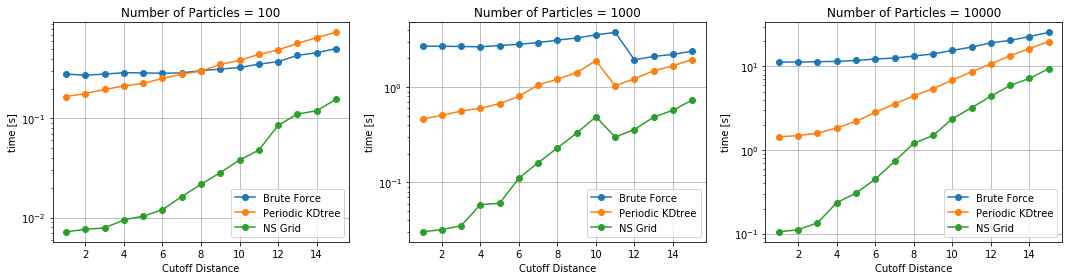

In [27]:
ncols = 3
fig, axes = plt.subplots(ncols=ncols, figsize = (15,4))

for i in range(ncols):
    ax = axes[i]
    ax.plot(cutoff, result['bf'+'.'+str(nquery[i])], 'o-', label='Brute Force')
    ax.plot(cutoff, result['pkdtree'+'.'+str(nquery[i])], 'o-', label='Periodic KDtree')
    ax.plot(cutoff, result['nsgrid'+'.'+str(nquery[i])], 'o-', label='NS Grid')

    ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Number of Particles = {}'.format(result['N'][i]))
    ax.legend()
    ax.grid(True)
fig.tight_layout()

For different size of queries, it can be seen that while there is a competition between brute force and KDtree, but Cell-list algorithm always have the superior performance. To have a better idea, it would be also be better to check whether this holds for smaller data sets as well. So lets change the size of data set to `10000 atoms` and change the number of query points accordingly

In [28]:
Npoints = 10000
cutoff = np.linspace(1, 15, num=15, dtype=np.float)
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
nquery = np.logspace(2, 4, num=3, dtype=np.int)

In [29]:
from collections import defaultdict

result = defaultdict(list)

points = get_coords(box, Npoints)
for n in tqdm_notebook(np.unique(nquery)):
    for cut in tqdm_notebook(np.unique(cutoff)):
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='bruteforce')
        result['bf'+'.'+str(n)].append(res.average)
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='pkdtree')
        result['pkdtree'+'.'+str(n)].append(res.average)
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='nsgrid')
        result['nsgrid'+'.'+str(n)].append(res.average)
    
    result['N'].append(n)

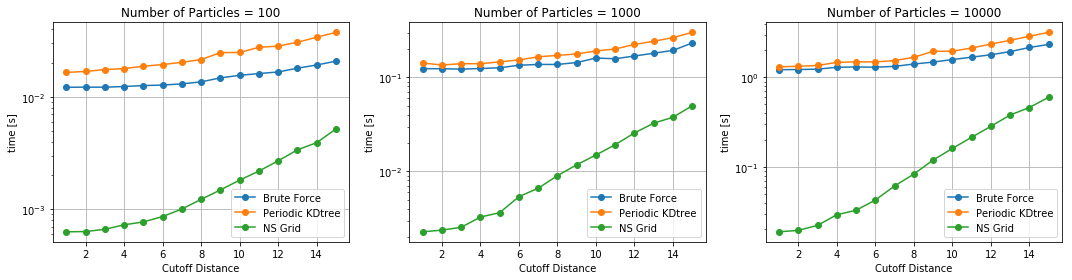

In [30]:
ncols = 3
fig, axes = plt.subplots(ncols=ncols, figsize = (15,4))

for i in range(ncols):
    ax = axes[i]
    ax.plot(cutoff, result['bf'+'.'+str(nquery[i])], 'o-', label='Brute Force')
    ax.plot(cutoff, result['pkdtree'+'.'+str(nquery[i])], 'o-', label='Periodic KDtree')
    ax.plot(cutoff, result['nsgrid'+'.'+str(nquery[i])], 'o-', label='NS Grid')

    ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Number of Particles = {}'.format(result['N'][i]))
    ax.legend()
    ax.grid(True)
fig.tight_layout()

As can be seen, NSGrid has always superior performance over bruteforce and kdtree for searching between two set of data.

Lets check if toggling PBC `off` has any effect on the performance or not.

In [31]:
# single query
box = None
size = np.array([100, 100, 100])
max_dist = 4.0
Npoints = np.logspace(2, 5, num=10, dtype=np.int)

In [32]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(size, N)
    
    res = %timeit -q -o capped_distance(points[0], points, max_dist, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o capped_distance(points[0], points, max_dist, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o capped_distance(points[0], points, max_dist, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['N'].append(N)

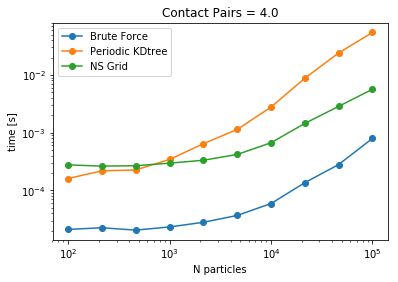

In [33]:
fig, axes = plt.subplots()

axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['N'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

While it definitely has some effects on the NS grid i.e. it becomes a little slow due to its handling of PBC for smaller data sets, but brute force remains to be the best performing case. Similar to earlier study, lets check the effect of multiple queries due to no PBC.

In [34]:
# multiple query
Npoints = 100000
max_dist = 4.0
box = None
size = np.array([100, 100, 100])
nquery = np.logspace(1, 5, num=10, dtype=np.int)

In [35]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

points = get_coords(size, Npoints)
for n in tqdm_notebook(np.unique(nquery)):
    
    
    res = %timeit -q -o capped_distance(points[:n], points, max_dist, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o capped_distance(points[:n], points, max_dist, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o capped_distance(points[:n], points, max_dist, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['N'].append(n)

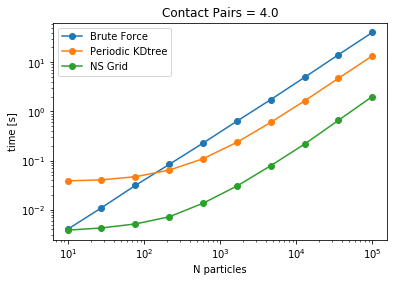

In [36]:
fig, axes = plt.subplots()

axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['N'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

As anticipated from the previous results, NS grid is the fastest among other methods for size of the query >= 10.

To understand whether the trend remains constant for different cutoff radius, lets repeat the above exercise already done for PBC

In [38]:
# cutoff variation - single queries
cutoff = np.linspace(1, 15, num=15, dtype=np.float)
Npoints = 100000
box = None
size = np.array([100, 100, 100])
points = get_coords(size,Npoints)
query = points[0]

In [40]:
result = defaultdict(list)

points = get_coords(size, Npoints)
for cut in tqdm_notebook(np.unique(cutoff)):
    
    res = %timeit -q -o capped_distance(query, points, cut, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o capped_distance(query, points, cut, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o capped_distance(query, points, cut, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['cut'].append(cut)

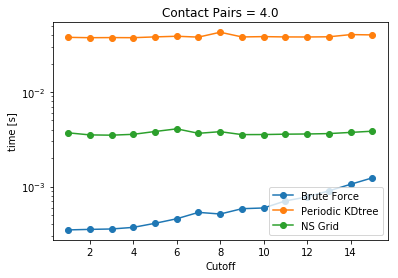

In [41]:
fig, axes = plt.subplots()

axes.plot(result['cut'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['cut'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['cut'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='Cutoff', ylabel='time [s]',  yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

For single queries, again, brute force is the superior one even during No-PBC. This can be extended  for multiple queries but for a case of data size of `100000` atoms as can be seen below

In [42]:
# cutoff with multiple queries
Npoints = 100000
cutoff = np.linspace(1, 15, num=15, dtype=np.float)
box = None
size = np.array([100, 100, 100])
nquery = np.logspace(2, 4, num=3, dtype=np.int)

In [43]:
from collections import defaultdict

result = defaultdict(list)

points = get_coords(size, Npoints)
for n in tqdm_notebook(np.unique(nquery)):
    for cut in tqdm_notebook(np.unique(cutoff)):
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='bruteforce')
        result['bf'+'.'+str(n)].append(res.average)
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='pkdtree')
        result['pkdtree'+'.'+str(n)].append(res.average)
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='nsgrid')
        result['nsgrid'+'.'+str(n)].append(res.average)
    
    result['N'].append(n)

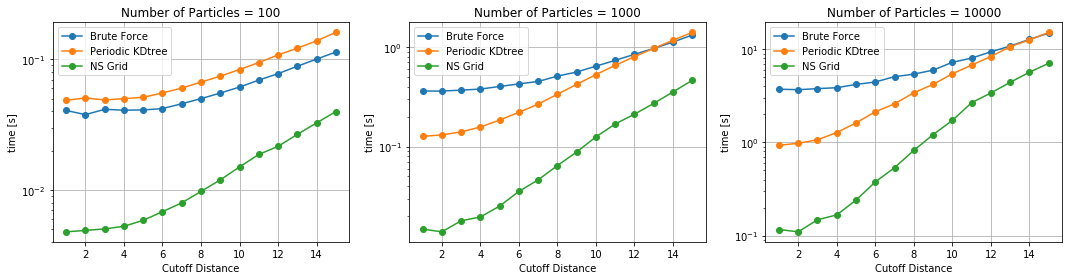

In [44]:
ncols = 3
fig, axes = plt.subplots(ncols=ncols, figsize = (15,4))

for i in range(ncols):
    ax = axes[i]
    ax.plot(cutoff, result['bf'+'.'+str(nquery[i])], 'o-', label='Brute Force')
    ax.plot(cutoff, result['pkdtree'+'.'+str(nquery[i])], 'o-', label='Periodic KDtree')
    ax.plot(cutoff, result['nsgrid'+'.'+str(nquery[i])], 'o-', label='NS Grid')

    ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Number of Particles = {}'.format(result['N'][i]))
    ax.legend()
    ax.grid(True)
fig.tight_layout()

Here again, NS Grid is the fastest for all the cutoff distances

To make sure, another instance with data size of `10000` atoms is also tested for distance evaluations

In [5]:
Npoints = 10000
cutoff = np.linspace(1, 15, num=15, dtype=np.float)
box = None
size = np.array([100, 100, 100])
nquery = np.logspace(2, 4, num=3, dtype=np.int)

In [7]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

points = get_coords(size, Npoints)
for n in tqdm_notebook(np.unique(nquery)):
    for cut in tqdm_notebook(np.unique(cutoff)):
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='bruteforce')
        result['bf'+'.'+str(n)].append(res.average)
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='pkdtree')
        result['pkdtree'+'.'+str(n)].append(res.average)
    
        res = %timeit -q -o capped_distance(points[:n], points, cut, box=box, method='nsgrid')
        result['nsgrid'+'.'+str(n)].append(res.average)
    
    result['N'].append(n)

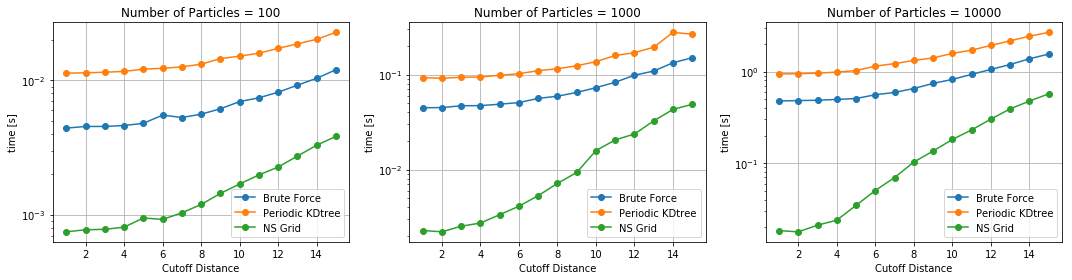

In [8]:
ncols = 3
fig, axes = plt.subplots(ncols=ncols, figsize = (15,4))

for i in range(ncols):
    ax = axes[i]
    ax.plot(cutoff, result['bf'+'.'+str(nquery[i])], 'o-', label='Brute Force')
    ax.plot(cutoff, result['pkdtree'+'.'+str(nquery[i])], 'o-', label='Periodic KDtree')
    ax.plot(cutoff, result['nsgrid'+'.'+str(nquery[i])], 'o-', label='NS Grid')

    ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Number of Particles = {}'.format(result['N'][i]))
    ax.legend()
    ax.grid(True)
fig.tight_layout()

As can be seen, the trend is still similar. While there can be some variations at different sizes, but with current benchmarks, it seems Cell-list structure is almost always offer superior performance.

# Self Search

Another segment is to search all the pairs within a certain distance among the coordinates. This is inbuilt in a different function called ``self_capped_distance`` which is located in `lib.distances` 

Lets begin by checking the performance variation due to size of the data with PBC

In [5]:
# self search - pbc
Npoints = np.logspace(2, 5, num=10, dtype=np.int)
max_dist = 4.0
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)

In [9]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(box, N)
    
    res = %timeit -q -o self_capped_distance(points, max_dist, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, max_dist, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, max_dist, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['N'].append(N)

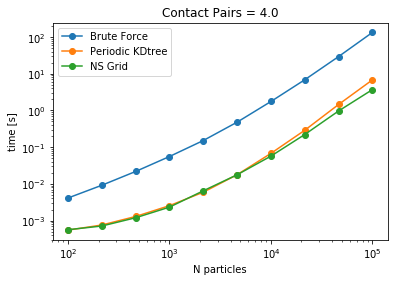

In [10]:
fig, axes = plt.subplots()

axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['N'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

For the self search, pkdtree and nsgrid seems to be of equal performance for a cutoff distance of 4 units. It is beneficial to check if the relationship holds for all the cutoff distances. Two different size of datasets (``100000`` and ``10000``) are tested for find all the neighbouring pairs. 

In [6]:
# self search - pbc - cutoff
cutoff = np.linspace(1, 9, num=9, dtype=np.float)
Npoints = 100000
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
points = get_coords(box,Npoints)

In [ ]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

points = get_coords(box, Npoints)
for cut in tqdm_notebook(np.unique(cutoff)):
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['cut'].append(cut)

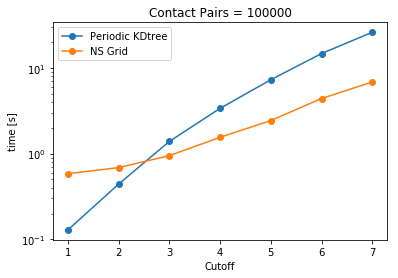

In [10]:
fig, axes = plt.subplots()

axes.plot(result['cut'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['cut'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='Cutoff', ylabel='time [s]',  yscale='log', title='Contact Pairs = {}'.format(Npoints))
axes.legend()

Apparently, bruteforce takes along time for such calculations, and therefore, the other two methods are used here for benchmarks. It can be sen than KDtree is better suited for smaller cutoff calculations, while NS Grid is better for larger cutoff distances. To build more confidence on this trend, another dataset of size 10000 points is tested.

In [11]:
cutoff = np.linspace(1, 15, num=15, dtype=np.float)
Npoints = 10000
box = np.array([100, 100, 100, 90, 90, 90], dtype = np.float32)
points = get_coords(box,Npoints)

In [12]:
result = defaultdict(list)

points = get_coords(box, Npoints)
for cut in tqdm_notebook(np.unique(cutoff)):
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['cut'].append(cut)

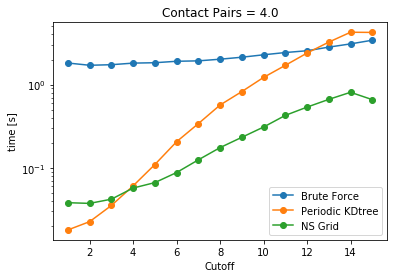

In [13]:
fig, axes = plt.subplots()

axes.plot(result['cut'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['cut'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['cut'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='Cutoff', ylabel='time [s]',  yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

As seen above, NSgrid shows superior performance after a certain cutoff distance, while Periodic KDtree is better before the critical cutoff distance. Another observation could be the movement of the critical cutoff radius due to decrease in data size. With decrease in data size, cutoff distancemoves towards higher values. While more number of sample points needs to be studied to understand the trend, a nominal value of cutoff distance = 3 can be chosen as a critical cutoff distance.

Inorder to be complete, the effect of no PBC should also be studied. 

In [7]:
# self search - nopbc
Npoints = np.logspace(2, 5, num=10, dtype=np.int)
max_dist = 4.0
box = None
size = np.array([100., 100., 100])

In [8]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(size, N)
    
    res = %timeit -q -o self_capped_distance(points, max_dist, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, max_dist, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, max_dist, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['N'].append(N)

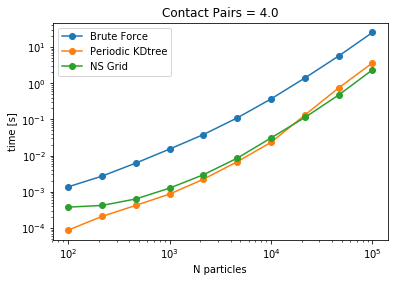

In [9]:
fig, axes = plt.subplots()

axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['N'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

In [15]:
# self search - nopbc - cutoff
cutoff = np.linspace(1, 9, num=9, dtype=np.float)
Npoints = 100000
box = None
size = np.array([100., 100., 100.])
points = get_coords(size,Npoints)

In [16]:
result = defaultdict(list)

points = get_coords(size, Npoints)
for cut in tqdm_notebook(np.unique(cutoff)):
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['cut'].append(cut)

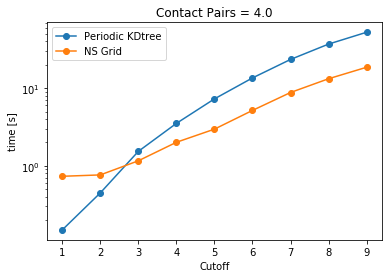

In [17]:
fig, axes = plt.subplots()

axes.plot(result['cut'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['cut'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='Cutoff', ylabel='time [s]',  yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

In [12]:
cutoff = np.linspace(1, 9, num=9, dtype=np.float)
Npoints = 10000
box = None
size = np.array([100., 100., 100.])
points = get_coords(size,Npoints)

In [13]:
result = defaultdict(list)

points = get_coords(size, Npoints)
for cut in tqdm_notebook(np.unique(cutoff)):
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='bruteforce')
    result['bf'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='pkdtree')
    result['pkdtree'].append(res.average)
    
    res = %timeit -q -o self_capped_distance(points, cut, box=box, method='nsgrid')
    result['nsgrid'].append(res.average)
    
    result['cut'].append(cut)

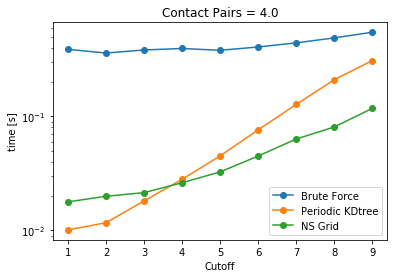

In [14]:
fig, axes = plt.subplots()

axes.plot(result['cut'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['cut'], result['pkdtree'], 'o-', label='Periodic KDtree')
axes.plot(result['cut'], result['nsgrid'], 'o-', label='NS Grid')

axes.set(xlabel='Cutoff', ylabel='time [s]',  yscale='log', title='Contact Pairs = {}'.format(max_dist))
axes.legend()

These are similar trends as were observed for PBC conditions

In conclusion, following decisions can be made:

* For atom selections, nsgrid offers the best performance if the size of query atoms is more than 10, otherwise, bruteforce should be used.
* For self search, pkdtree should be used for a cutoff distance below 3% of the box size, while capped grid should be used above it. 